In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster
from sklearn.metrics import mean_squared_error

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

In [2]:
# champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [16]:
convention_df.isna().sum()/convention_df["Identifiant arc"].count()

Identifiant arc              0.000000
Libelle                      0.000000
Date et heure de comptage    0.000000
Débit horaire                0.449751
Taux d'occupation            0.437348
Etat trafic                  0.000000
Identifiant noeud amont      0.000000
Libelle noeud amont          0.000000
Identifiant noeud aval       0.000000
Libelle noeud aval           0.000000
Etat arc                     0.000000
Date debut dispo data        0.000000
Date fin dispo data          0.000000
geo_point_2d                 0.000000
geo_shape                    0.000000
date                         0.000000
hour                         0.000000
year                         0.000000
month                        0.000000
weekday                      0.000000
is_weekend                   0.000000
hour_sin                     0.000000
hour_cos                     0.000000
weekday_sin                  0.000000
weekday_cos                  0.000000
month_sin                    0.000000
month_cos   

In [3]:
preprocessor = Preprocessor(df=convention_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 45)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event,Débit horaire_outlier_iqr,Taux d'occupation_outlier_iqr
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2024-10-22 09:00:00,5671,Convention,NaN,NaN,Inconnu,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-06-24 09:00:00,5671,Convention,630.0,6.05000,Fluide,2937,Lecourbe-Convention,2973,Convention-Blomet,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2024-11-12 07:00:00,5671,Convention,NaN,NaN,Inconnu,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-08-14 14:00:00,5671,Convention,377.0,2.49889,Fluide,2937,Lecourbe-Convention,2973,Convention-Blomet,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-10-28 22:00:00,5671,Convention,306.0,2.14611,Fluide,2937,Lecourbe-Convention,2973,Convention-Blomet,Ouvert,...,10.7,0.0,1006.8,0.0,11.6,0.0,NaN,False,False,False


# LSTM Forecasting

In [4]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False,
    use_outliers=True
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_processed)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)


Epoch 1/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0422 - val_loss: 0.0439
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0234 - val_loss: 0.0346
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0191 - val_loss: 0.0219
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0174 - val_loss: 0.0214
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0163 - val_loss: 0.0211


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Débit horaire : RMSE = 186.62, Mean = 409.50, Relative error = 45.57%
Taux d'occupation : RMSE = 3.10, Mean = 3.78, Relative error = 81.96%


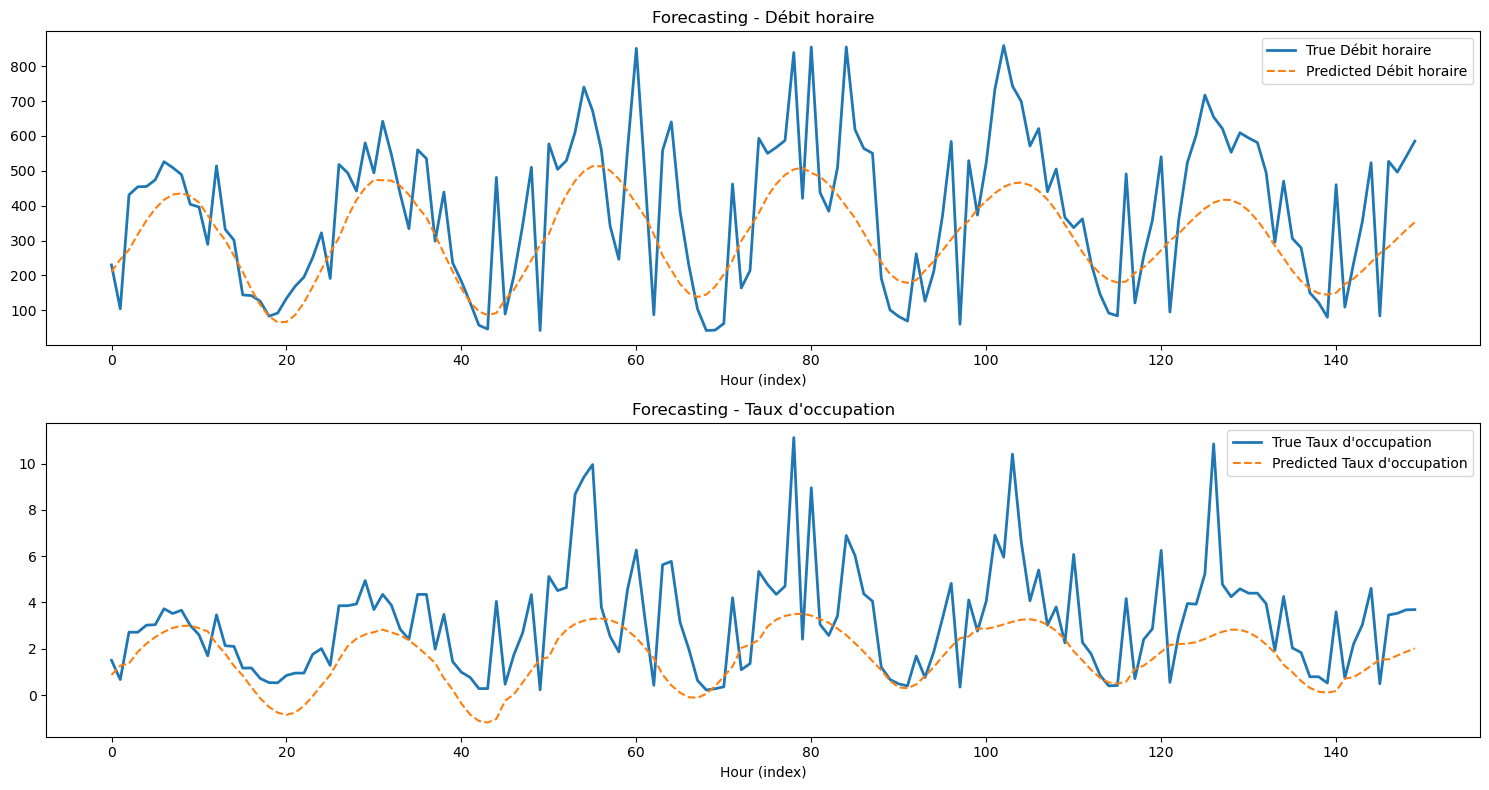

In [5]:
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=150)

In [6]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0768 - val_loss: 0.0988
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0407 - val_loss: 0.0869
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0371 - val_loss: 0.0806
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0331 - val_loss: 0.0841
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0266 - val_loss: 0.0857
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Débit horaire : RMSE = 186.03, Mean = 639.10, Relative error = 29.11%
Taux d'occupation : RMSE = 13.26, Mean = 15.17, Relative error = 87.43%
Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0752 - val_loss: 0.0222
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0338 - val_loss: 0.0177
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0303 - val_loss: 0.0137
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0281 - val_loss: 0.0131
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.02

# XGBoost model

In [7]:
from src.xgb_forecasting import XGBoostModel

Train set: (1417, 8), Test set: (72, 8) (72 hours)
Débit horaire : RMSE = 68.64, Mean = 389.14, Relative Error = 17.64%
Taux d'occupation : RMSE = 2.38, Mean = 3.49, Relative Error = 68.13%


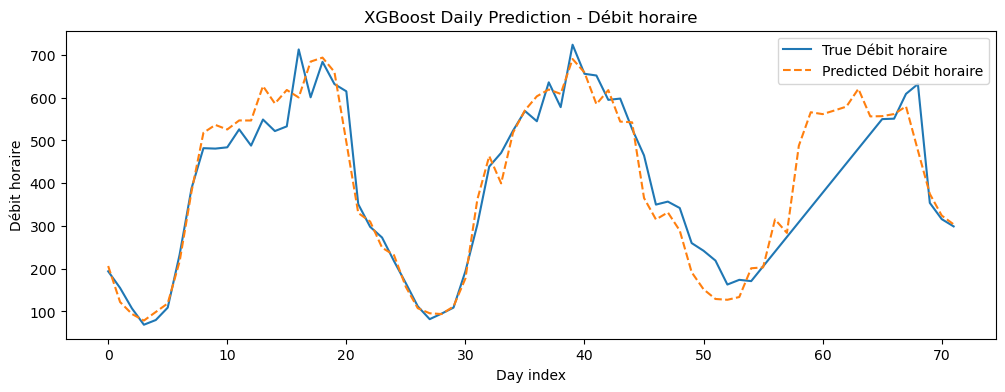

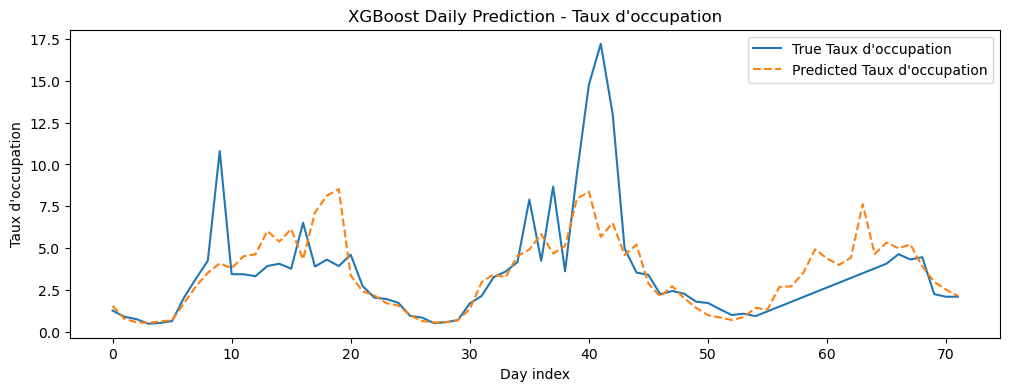

In [8]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

features_xgb += ['lag_1d', 'lag_1w']

df_xgb = df_xgb.dropna(subset=['lag_1d', 'lag_1w'] + targets).copy()

xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [9]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 114.66, std = 42.87
Taux d'occupation : CV RMSE mean = 5.05, std = 3.94


# Hybrid LSTM + XGBoost model 

In [10]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']

# Instanciate XGBoost
xgb_model = XGBoostModel(df_processed, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0429 - val_loss: 0.0443
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0236 - val_loss: 0.0400
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0196 - val_loss: 0.0249
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0172 - val_loss: 0.0222
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0158 - val_loss: 0.0224
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Débit horaire : RMSE = 191.73, Mean = 409.50, Relative error = 46.82%
Taux d'occupation : RMSE = 3.17, Mean = 3.78, Relative error = 83.96%
Train set: (1417, 6), Test set: (72, 6) (72 hours)


In [11]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.7
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Débit horaire : RMSE = 191.73, Mean = 409.50, Relative error = 46.82%
Taux d'occupation : RMSE = 3.17, Mean = 3.78, Relative error = 83.96%
LSTM Prediction Array Shape : (1443, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 143.46, Mean = 388.82, Relative Error = 36.90%
Taux d'occupation : RMSE = 2.96, Mean = 3.48, Relative Error = 84.87%


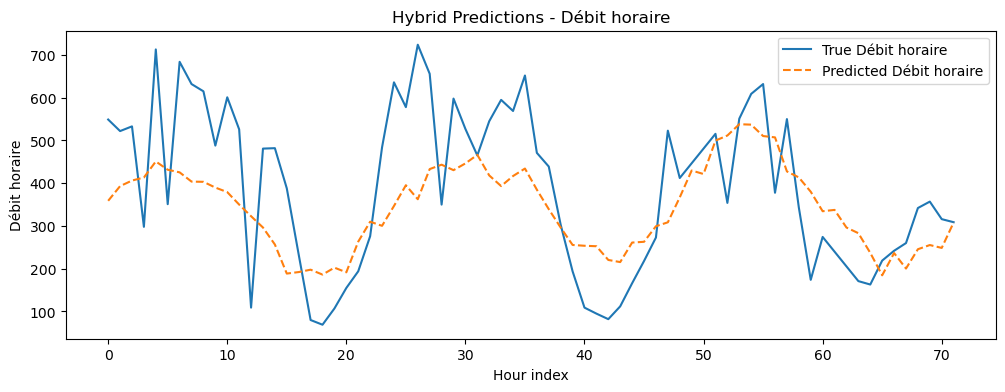

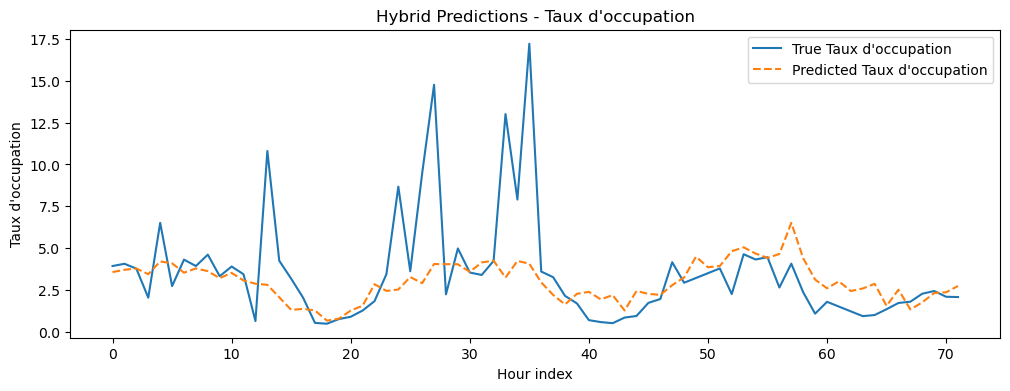

In [12]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()